<a href="https://colab.research.google.com/github/PaolaMaribel18/RI_2024a/blob/main/week14/imagesearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Collection and Preprocessing

Work with the Caltech101 dataset. Preprocessing usually involves resizing the images to a consistent size and normalize the pixel values.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [ ]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = dataset_info.features['label'].num_classes

def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

### Feature Extraction

Use a pre-trained CNN model (e.g., VGG16) to extract features from the images.

Remove the top layers to get the feature vectors.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load the VGG16 model with pretrained weights from ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs the feature maps
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Function to extract features
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    return features, labels

# Extract features for train and test datasets
train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)

1/1 [==============================] - 3s 3s/step


### Indexing

Use an in-memory index using NumPy. Other alternatives are more scalable solutions like FAISS or an approximate nearest neighbor search library.

In [ ]:
# Flatten the feature maps to create feature vectors
train_features_flat = np.array([feature.flatten() for batch in train_features for feature in batch])
train_labels_flat = np.array([label for batch in train_labels for label in batch])

# Optionally, save the features and labels for later use
np.save('train_features.npy', train_features_flat)
np.save('train_labels.npy', train_labels_flat)

In [ ]:
# Load the saved features and labels
train_features_flat = np.load('train_features.npy')
train_labels_flat = np.load('train_labels.npy')

In [ ]:
# Example query: Retrieve the 5 nearest neighbors for a test image
from sklearn.neighbors import NearestNeighbors

# Fit the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_flat)

# Extract features from a single query image
query_image, _ = next(iter(test_dataset.take(1)))
query_image = query_image[5]  # Get the image in the batch
query_image = tf.expand_dims(query_image, axis=0)  # Add batch dimension
query_features = model.predict(query_image).flatten().reshape(1, -1)
query_image_display = query_image.numpy()

# Find the nearest neighbors
distances, indices = nn_model.kneighbors(query_features)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

1/1 [==============================] - 1s 1s/step
Indices of nearest neighbors: [[1845 1700 1715 1758 1701]]
Distances to nearest neighbors: [[40.91172776 41.16591395 42.48329353 42.70308089 43.06900571]]


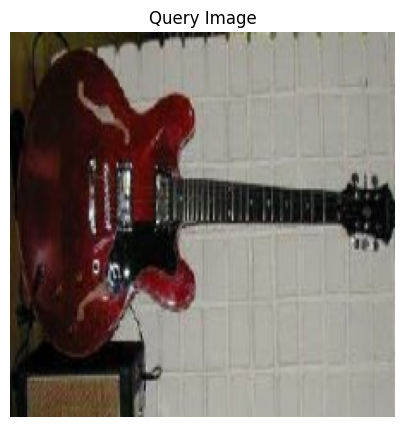

In [ ]:
import matplotlib.pyplot as plt

# Extract a batch of images from the test dataset
query_image_batch, _ = next(iter(test_dataset.take(1)))

# Get a single image from the batch
query_image = query_image_batch[5]  # Adjust the index as needed

# Convert the image to a NumPy array for visualization
query_image_display = query_image.numpy()

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(query_image_display)
plt.title("Query Image")
plt.axis('off')  # Hide axis
plt.show()


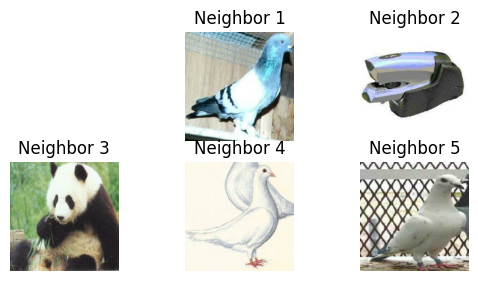

In [ ]:
# Display the nearest neighbor images
neighbor_images = [train_dataset.unbatch().skip(index).take(1) for index in indices[0]]
for i, neighbor in enumerate(neighbor_images):
    for image, label in neighbor:
        plt.subplot(3, 3, i+2)
        plt.imshow(image)
        plt.title(f"Neighbor {i+1}")
        plt.axis('off')

plt.show()

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
test_features_flat = np.array([feature.flatten() for batch in test_features for feature in batch])
test_labels_flat = np.array([label for batch in test_labels for label in batch])
# Predict on the test dataset
def predict_nearest_neighbors(features):
    distances, indices = nn_model.kneighbors(features)
    return indices

# Predict on the test dataset
test_predictions = predict_nearest_neighbors(test_features_flat)

# Take only the first predicted neighbor for each test sample
test_predictions = test_predictions[:, 0]  # Select the index of the nearest neighbor

# Convert predictions to a flat list for evaluation
predicted_labels = [train_labels_flat[index] for index in test_predictions]

# Convert predicted labels and true labels to 1D arrays for classification report
y_true = np.array(test_labels_flat)
y_pred = np.array(predicted_labels)


In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         3
     Class 1       1.00      0.67      0.80         3
     Class 2       0.00      0.00      0.00         6
     Class 3       0.00      0.00      0.00         3
     Class 4       0.07      0.29      0.12         7
     Class 5       0.75      0.50      0.60         6
     Class 6       0.50      0.50      0.50         4
     Class 7       1.00      0.29      0.44         7
     Class 8       1.00      0.20      0.33         5
     Class 9       0.00      0.00      0.00         6
    Class 10       0.57      1.00      0.73         4
    Class 11       1.00      0.38      0.55         8
    Class 12       0.25      0.60      0.35         5
    Class 13       0.50      0.17      0.25         6
    Class 14       1.00      0.50      0.67         6
    Class 15       0.57      0.67      0.62         6
    Class 16       0.75      1.00      0.86         3
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
